In [1]:
import gym
import hiive.mdptoolbox, hiive.mdptoolbox.example, hiive.mdptoolbox.mdp
import hiive.mdptoolbox as mdptoolbox
import hiive.visualization
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42) 
# set this so that in QL taking random actions based upon the value of epsilon, 
# you're generating random numbers consistently to compare against epsilon
N_EPISODES = 1000

In [2]:
def setup_game(dim):
    # from gym implementation
    MAPS = {
        '4x4': ['SFFH',
                'FHFF',
                'FFFF',
                'HFFG'
        ],
        '8x8': ["SFFFFFFF",
                "FFFFFFFF",
                "FFFHFFFF",
                "FFFFFHFF",
                "FFFHFFFF",
                "FHHFFFHF",
                "FHFFHFFF",
                "FFFHFFFG"],
        '12x12': ['SFFFFHHFFHFF', 'FFFFFFFFFFFF', 'HFFFFFFFHHFF', 'FFFFFFFFHFFF', 
                  'FFFFFFHHFFFH', 'HFFFFFFFFFFF', 'FFFFHFHFHHHH', 'FFFFFFFHFFFH', 
                  'FFFFFFFHHHFF', 'FFFFFFHFFFFH', 'FFHFHFFFFFFF', 'FFFHFFFFHFFG'],
        '20x20': ['SHFFFFFHFFFHHFFFFFFF', 'FFFFFFFFFFFFFHHHFFFF', 'FFFHFFFFFFHFHHFHFFFF', 
                  'FFHFFFFHFHFFFHFFFFFF', 'HFFFFFFFHFFFFFFFFFFF', 'FFFFHFFFFFFFHHFHHFHF', 
                  'HHFFFFHHFFFFFFHFFFFH', 'HFFFFFFFFFHFFFHFFFFF', 'FFFFFHFFFFFFFFFFFFHF', 
                  'FFHHFFHFFFFHHFFFFHHF', 'FFFHFFFFFFFFFFFFFFFH', 'FFFFFFHFHFFFFFFFFFFF', 
                  'HHHFFHFHHHFFHFFFHFFF', 'FHFFHFFFFFHHHHFFFFFF', 'HFFFFFFFFFFFHFFFFFFF', 
                  'FFFFFHFFFFFFFHHFFFFF', 'FFFFHFFFFFFFFFFFHFFF', 'FFFFFFFFFFFHFFFFFFHF', 
                  'FFFFHFHHFFFFFFFFHFHF', 'FFFHFHFFFHHFFFFHHFFG']
            }

    # order from ai gym for my sanity
    actions = ['LEFT', 'DOWN', 'RIGHT', 'UP']

    # Environment
    # from https://gym.openai.com/docs/
    # https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym
    curr_map = MAPS[dim]
    # slippery for stochastic 
    env = gym.make('FrozenLake-v0', desc=curr_map, is_slippery=True)

    # check environment
    env.render()

    # Set up transition and rewards matrices
    env.reset() # just to be sure we're at the start state in the grid world
    n_size = env.nS
    print("# States: " + str(n_size))
    n_action = env.nA
    print("# Actions: " + str(n_action))

    # for visualization later
    env_state = []
    for r in curr_map:
        env_state.append(list(r))

    # from MDP docs, use numpy array that has the shape (A, S, S) for reward and (S, A) fors trans
    trans = np.zeros([n_action, n_size, n_size])
    reward = np.zeros([n_size, n_action])

    # P is the transition matrix
    for s, s_info in env.P.items():
        for a, a_info in s_info.items():
            for i, info in enumerate(a_info):
                p = info[0]
                s_prime = info[1]
                r = info[2]
                reward[s, a] = r
                trans[a, s, s_prime] += p

    # confirm that we have a valid reward and transition matrix
    mdptoolbox.util.check(trans, reward)
    return env, trans, reward, env_state


SHFFFFFHFFFHHFFFFFFF
FFFFFFFFFFFFFHHHFFFF
FFFHFFFFFFHFHHFHFFFF
FFHFFFFHFHFFFHFFFFFF
HFFFFFFFHFFFFFFFFFFF
FFFFHFFFFFFFHHFHHFHF
HHFFFFHHFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFHFFFFFFFFFFFFHF
FFHHFFHFFFFHHFFFFHHF
FFFHFFFFFFFFFFFFFFFH
FFFFFFHFHFFFFFFFFFFF
HHHFFHFHHHFFHFFFHFFF
FHFFHFFFFFHHHHFFFFFF
HFFFFFFFFFFFHFFFFFFF
FFFFFHFFFFFFFHHFFFFF
FFFFHFFFFFFFFFFFHFFF
FFFFFFFFFFFHFFFFFFHF
FFFFHFHHFFFFFFFFHFHF
FFFHFHFFFHHFFFFHHFFG
# States: 400
# Actions: 4


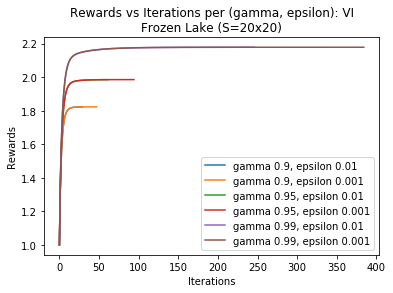

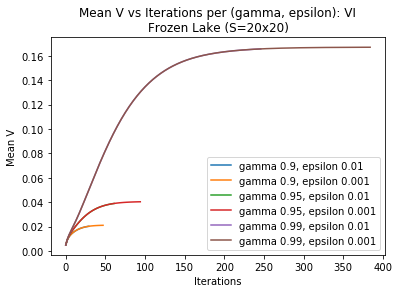

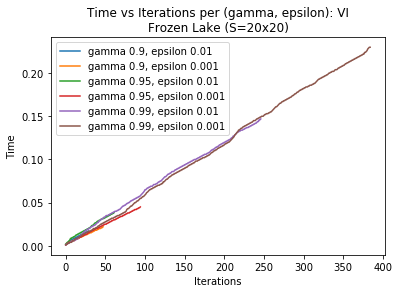

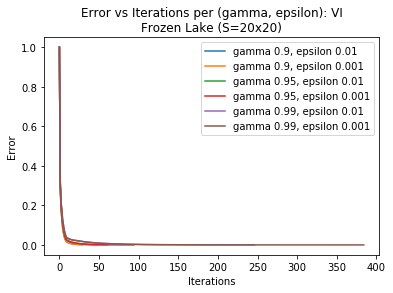

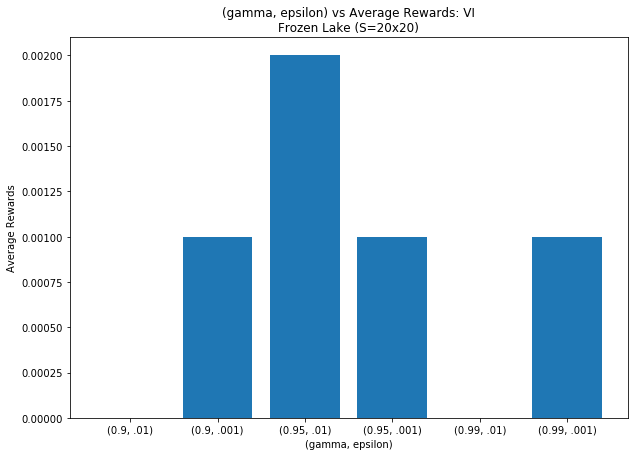

In [4]:
# Value Iteration (LARGER FOR COMPARISON TO 8x8)
env, trans_m, reward_m, env_state = setup_game('20x20')
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
epsilon = [.01, .001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
for g in gamma:
    for e in epsilon:
        vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=e ,gamma=g)
        vi.run()
        episode_rewards = []
        # play game
        for i_episode in range(N_EPISODES):
            state = env.reset() # reset state to s0.
            moves = 0
            done = False
            total_rewards = 0
            while not done:
                action = vi.policy[state]
                state, reward, done, info = env.step(action)
                moves += 1
                total_rewards += reward      
            env.close()
            episode_rewards.append(total_rewards)
        ave_rewards = sum(episode_rewards) / N_EPISODES
        avg_episode_rewards.append(ave_rewards)

        
        reward_stats = [stat['Reward'] for stat in vi.run_stats]
        plt.figure(1)
        plt.plot(range(0, vi.iter), reward_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Rewards vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=20x20)")
        plt.ylabel("Rewards")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Rewards_vs_Iterations_vi_gamma_larger.png')


        meanv_stats = [stat['Mean V'] for stat in vi.run_stats]
        plt.figure(2)
        plt.plot(range(0, vi.iter), meanv_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Mean V vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=20x20)")
        plt.ylabel("Mean V")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/MeanV_vs_Iterations_vi_gamma_larger.png')

        time_stats = [stat['Time'] for stat in vi.run_stats]
        plt.figure(3)
        plt.plot(range(0, vi.iter), time_stats, label="gamma " + str(g)  + ", epsilon " + str(e))
        plt.legend()
        plt.title("Time vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=20x20)")
        plt.ylabel("Time")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Time_vs_Iterations_vi_gamma_larger.png')

        err_stats = [stat['Error'] for stat in vi.run_stats]
        plt.figure(4)
        plt.plot(range(0, vi.iter), err_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Error vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=20x20)")
        plt.ylabel("Error")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Error_vs_Iterations_vi_gamma_larger.png')
    
tick_labels = ['(0.9, .01)', '(0.9, .001)', '(0.95, .01)', '(0.95, .001)', '(0.99, .01)', '(0.99, .001)']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5, figsize=[10, 7])
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("(gamma, epsilon) vs Average Rewards: VI\nFrozen Lake (S=20x20)")
plt.xlabel("(gamma, epsilon)")
plt.ylabel("Average Rewards")
plt.savefig('../images/vi_frozen/Average_Rewards_vs_Gamma_vi_larger.png')

iterations:385
Time: 0.17799925804138184
Policy: (0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 2, 1, 0, 1, 0, 3, 3, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 0, 0, 2, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 3, 2, 0, 0, 0, 1, 1, 0, 3, 1, 3, 3, 3, 2, 3, 3, 1, 3, 2, 0, 0, 2, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 3, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 3, 3, 3, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 3, 1, 1, 1, 3, 3, 0, 0, 2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 0, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 3, 0, 0, 0, 2, 3, 1, 3, 3, 3, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 3, 3, 3, 1, 3, 0, 0, 0, 0, 2, 3, 3, 3, 3, 2, 2, 3, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 0, 0, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 3,

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


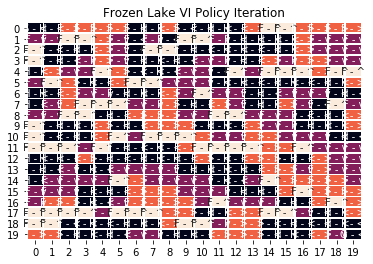

In [5]:
# Show Optimal policy (LARGER GRID)
vi_large = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.001, gamma=.99)
vi_large.run()
print('iterations:' + str(vi_large.iter))
print('Time: ' + str(vi_large.time))
print('Policy: ' + str(vi_large.policy))
print('Value: ' + str(vi_large.V))
visualize_policy(vi_large.policy, rl_type='VI', env_state=env_state)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4


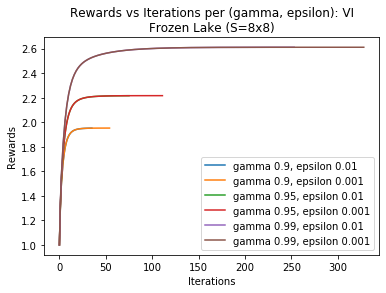

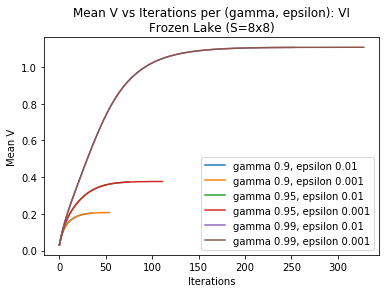

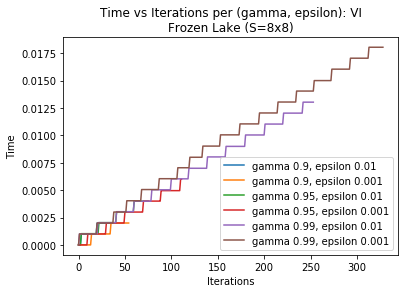

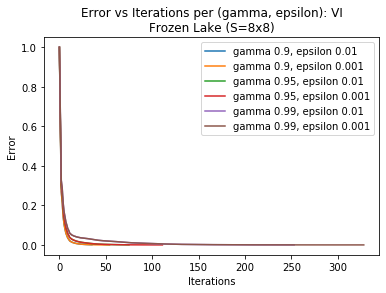

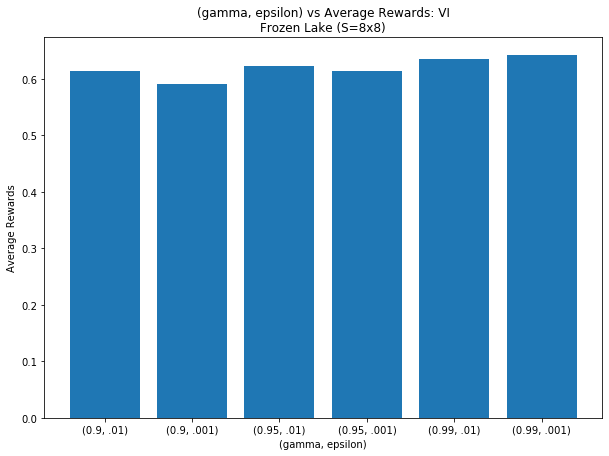

In [6]:
# Value Iteration (SMALL GRID WORLD)
env, trans_m, reward_m, env_state = setup_game('8x8')
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
epsilon = [.01, .001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
for g in gamma:
    for e in epsilon:
        vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=e ,gamma=g)
        vi.run()
        episode_rewards = []
        # play game
        for i_episode in range(N_EPISODES):
            state = env.reset() # reset state to s0.
            moves = 0
            done = False
            total_rewards = 0
            while not done:
                action = vi.policy[state]
                state, reward, done, info = env.step(action)
                moves += 1
                total_rewards += reward      
            env.close()
            episode_rewards.append(total_rewards)
        ave_rewards = sum(episode_rewards) / N_EPISODES
        avg_episode_rewards.append(ave_rewards)

        
        reward_stats = [stat['Reward'] for stat in vi.run_stats]
        plt.figure(1)
        plt.plot(range(0, vi.iter), reward_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Rewards vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=8x8)")
        plt.ylabel("Rewards")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Rewards_vs_Iterations_vi_gamma.png')


        meanv_stats = [stat['Mean V'] for stat in vi.run_stats]
        plt.figure(2)
        plt.plot(range(0, vi.iter), meanv_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Mean V vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=8x8)")
        plt.ylabel("Mean V")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/MeanV_vs_Iterations_vi_gamma.png')

        time_stats = [stat['Time'] for stat in vi.run_stats]
        plt.figure(3)
        plt.plot(range(0, vi.iter), time_stats, label="gamma " + str(g)  + ", epsilon " + str(e))
        plt.legend()
        plt.title("Time vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=8x8)")
        plt.ylabel("Time")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Time_vs_Iterations_vi_gamma.png')

        err_stats = [stat['Error'] for stat in vi.run_stats]
        plt.figure(4)
        plt.plot(range(0, vi.iter), err_stats, label="gamma " + str(g) + ", epsilon " + str(e))
        plt.legend()
        plt.title("Error vs Iterations per (gamma, epsilon): VI\nFrozen Lake (S=8x8)")
        plt.ylabel("Error")
        plt.xlabel("Iterations")
        plt.savefig('../images/vi_frozen/Error_vs_Iterations_vi_gamma.png')
    
tick_labels = ['(0.9, .01)', '(0.9, .001)', '(0.95, .01)', '(0.95, .001)', '(0.99, .01)', '(0.99, .001)']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5, figsize=[10, 7])
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("(gamma, epsilon) vs Average Rewards: VI\nFrozen Lake (S=8x8)")
plt.xlabel("(gamma, epsilon)")
plt.ylabel("Average Rewards")
plt.savefig('../images/vi_frozen/Average_Rewards_vs_Gamma_vi.png')
    
    


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4
iterations:329
Time: 0.020034313201904297
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0)
Value: (1.2239845898022712, 1.2610871903065644, 1.3169898105484457, 1.382341020260705, 1.4531588587589837, 1.5229727675154048, 1.5732566798144367, 1.587910727794461, 1.215278179667534, 1.2434107295837848, 1.291557696357813, 1.3534214724062612, 1.4273881511731323, 1.5188467578346005, 1.606283995270743, 1.6360360463936792, 1.1726766291351813, 1.1656233184511418, 1.1161165467271403, 0.0, 1.2875136561694756, 1.473316224786282, 1.6582411240622765, 1.7153713321877035, 1.0954320843388057, 1.0513949097133273, 0.9250013297228297, 0.6355323166720418, 1.0008593629896003, 0.0, 1.703323834875033, 1.824488267306267, 0.9867557219592236, 0.8678232440350989, 0.591629

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


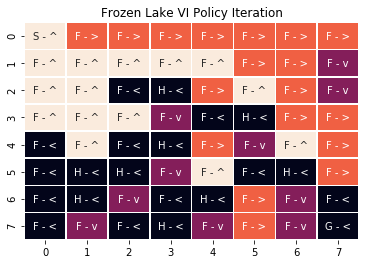

In [7]:
# Show Optimal policy
env, trans_m, reward_m, env_state = setup_game('8x8')
vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.001, gamma=.99)
vi.run()
print('iterations:' + str(vi.iter))
print('Time: ' + str(vi.time))
print('Policy: ' + str(vi.policy))
print('Value: ' + str(vi.V))
visualize_policy(vi.policy, rl_type='VI', env_state=env_state)


SHFFFFFHFFFHHFFFFFFF
FFFFFFFFFFFFFHHHFFFF
FFFHFFFFFFHFHHFHFFFF
FFHFFFFHFHFFFHFFFFFF
HFFFFFFFHFFFFFFFFFFF
FFFFHFFFFFFFHHFHHFHF
HHFFFFHHFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFHFFFFFFFFFFFFHF
FFHHFFHFFFFHHFFFFHHF
FFFHFFFFFFFFFFFFFFFH
FFFFFFHFHFFFFFFFFFFF
HHHFFHFHHHFFHFFFHFFF
FHFFHFFFFFHHHHFFFFFF
HFFFFFFFFFFFHFFFFFFF
FFFFFHFFFFFFFHHFFFFF
FFFFHFFFFFFFFFFFHFFF
FFFFFFFFFFFHFFFFFFHF
FFFFHFHHFFFFFFFFHFHF
FFFHFHFFFHHFFFFHHFFG
# States: 400
# Actions: 4


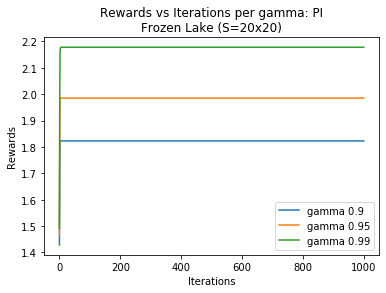

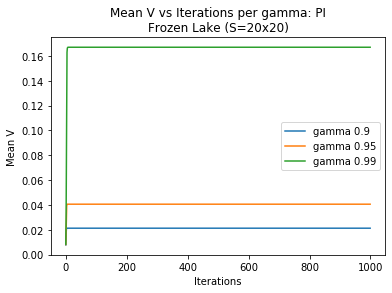

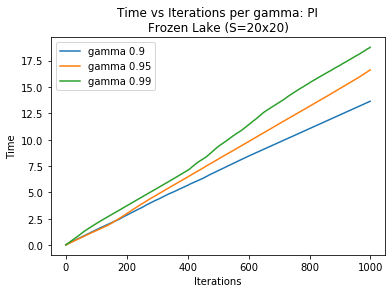

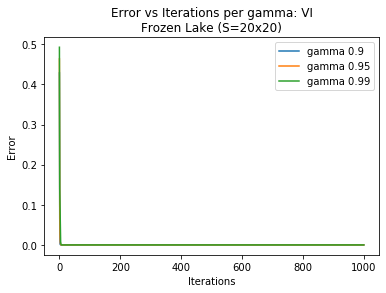

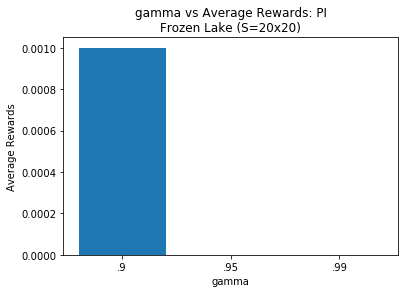

In [8]:
# Policy Iteration (LARGER GRID WORLD)
env, trans_m, reward_m, env_state = setup_game('20x20')
# hparams tuning
# gamma
gamma = [.9, .95, .99]

# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
for g in gamma:
    pi_large = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=g)
    pi_large.run()
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = pi_large.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward      
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in pi_large.run_stats]
    plt.figure(1)
    plt.plot(range(0, pi_large.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: PI\nFrozen Lake (S=20x20)")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Rewards_vs_Iterations_pi_gamma_large.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in pi_large.run_stats]
    plt.figure(2)
    plt.plot(range(0, pi_large.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: PI\nFrozen Lake (S=20x20)")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/MeanV_vs_Iterations_pi_gamma_large.png')
    
    time_stats = [stat['Time'] for stat in pi_large.run_stats]
    plt.figure(3)
    plt.plot(range(0, pi_large.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: PI\nFrozen Lake (S=20x20)")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Time_vs_Iterations_pi_gamma_large.png')
    
    err_stats = [stat['Error'] for stat in pi_large.run_stats]
    plt.figure(4)
    plt.plot(range(0, pi_large.iter), err_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Error vs Iterations per gamma: VI\nFrozen Lake (S=20x20)")
    plt.ylabel("Error")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Error_vs_Iterations_pi_gamma_large.png')

tick_labels = ['.9', '.95', '.99']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5)
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("gamma vs Average Rewards: PI\nFrozen Lake (S=20x20)")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/pi_frozen/Average_Rewards_vs_Gamma_pi_large.png')    

iterations:1000
Time: 13.391677141189575
Policy: (0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 3, 3, 2, 2, 0, 0, 1, 1, 3, 3, 2, 1, 0, 1, 3, 3, 3, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 3, 3, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 0, 1, 2, 1, 0, 0, 3, 0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 3, 2, 1, 0, 0, 2, 1, 0, 3, 1, 3, 3, 3, 2, 3, 3, 1, 3, 2, 0, 0, 2, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 3, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 3, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 3, 1, 1, 3, 3, 3, 0, 0, 2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 0, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 3, 0, 1, 0, 2, 3, 1, 3, 3, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 3, 3, 3, 1, 3, 3, 0, 0, 0, 2, 2, 3, 3, 2, 2, 2, 3, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 3, 2, 2, 1, 1, 1, 1, 0, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 2, 3, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 3,

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


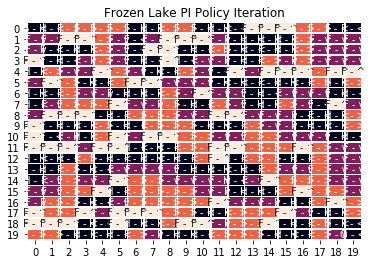

In [9]:
# Show Optimal policy (larger grid world)
# picked based on highest avg rewards and highest mean V
pi_large = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=.9)
pi_large.run()
print('iterations:' + str(pi_large.iter))
print('Time: ' + str(pi_large.time))
print('Policy: ' + str(pi_large.policy))
print('Value: ' + str(pi_large.V))
# Did they converge to the same policy?
print(vi_large.policy == pi_large.policy)
visualize_policy(pi_large.policy, rl_type='PI', env_state=env_state)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4


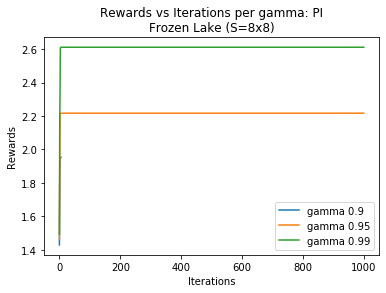

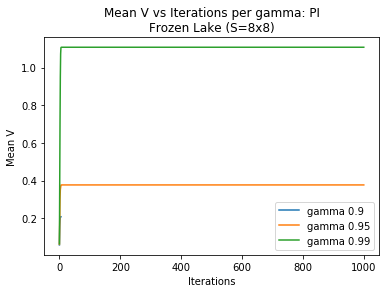

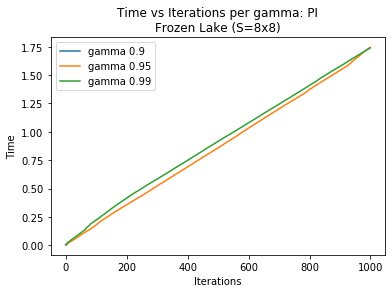

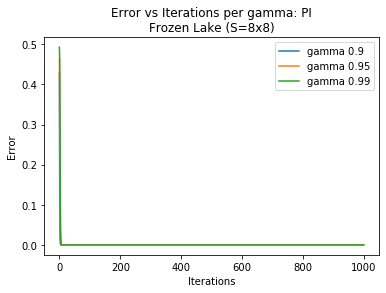

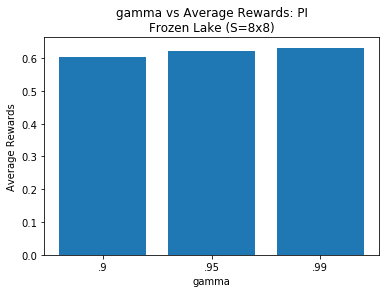

In [10]:
# Policy Iteration
env, trans_m, reward_m, env_state = setup_game('8x8')
# hparams tuning
# gamma
gamma = [.9, .95, .99]

# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
for g in gamma:
    pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=g)
    pi.run()
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = pi.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward      
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in pi.run_stats]
    plt.figure(1)
    plt.plot(range(0, pi.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: PI\nFrozen Lake (S=8x8)")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Rewards_vs_Iterations_pi_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in pi.run_stats]
    plt.figure(2)
    plt.plot(range(0, pi.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: PI\nFrozen Lake (S=8x8)")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/MeanV_vs_Iterations_pi_gamma.png')
    
    time_stats = [stat['Time'] for stat in pi.run_stats]
    plt.figure(3)
    plt.plot(range(0, pi.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: PI\nFrozen Lake (S=8x8)")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Time_vs_Iterations_pi_gamma.png')
    
    err_stats = [stat['Error'] for stat in pi.run_stats]
    plt.figure(4)
    plt.plot(range(0, pi.iter), err_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Error vs Iterations per gamma: PI\nFrozen Lake (S=8x8)")
    plt.ylabel("Error")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Error_vs_Iterations_pi_gamma.png')

tick_labels = ['.9', '.95', '.99']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5)
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("gamma vs Average Rewards: PI\nFrozen Lake (S=8x8)")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/pi_frozen/Average_Rewards_vs_Gamma_pi.png')    


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4
iterations:6
Time: 0.01499795913696289
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 1, 3, 3, 3, 3, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0)
Value: (0.0187306942453275, 0.024974258993770006, 0.035902545859288724, 0.05179267626121967, 0.07252307978235135, 0.09190479929551176, 0.11122304086766623, 0.1204441269194664, 0.017614894016358056, 0.022370725126174624, 0.03197993074378736, 0.04832649816049453, 0.0773157201966414, 0.10322149082186123, 0.13907630177175473, 0.16059216922595523, 0.015058880605703753, 0.017522494063617368, 0.02087283598275125, 8.0953762212251e-17, 0.08197449671792541, 0.11309053500560429, 0.19177246247889432, 0.23563875975547416, 0.012952985589501049, 0.015164752436465357, 0.020073695135099448, 0.030874728697781555, 0.08284206719083899, 0.0, 0.26452648006908547, 0.358051310

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


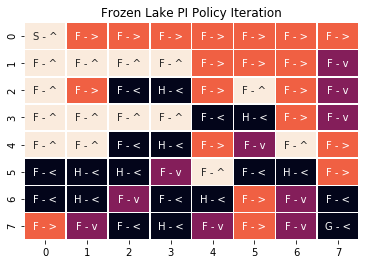

In [11]:
# Show Optimal policy
env, trans_m, reward_m, env_state = setup_game('8x8')
# picked based on highest avg rewards and highest mean V
pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=.9)
pi.run()
print('iterations:' + str(pi.iter))
print('Time: ' + str(pi.time))
print('Policy: ' + str(pi.policy))
print('Value: ' + str(pi.V))
# Did they converge to the same policy?
print(vi.policy == pi.policy)
visualize_policy(pi.policy, rl_type='PI', env_state=env_state)


SHFFFFFHFFFHHFFFFFFF
FFFFFFFFFFFFFHHHFFFF
FFFHFFFFFFHFHHFHFFFF
FFHFFFFHFHFFFHFFFFFF
HFFFFFFFHFFFFFFFFFFF
FFFFHFFFFFFFHHFHHFHF
HHFFFFHHFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFHFFFFFFFFFFFFHF
FFHHFFHFFFFHHFFFFHHF
FFFHFFFFFFFFFFFFFFFH
FFFFFFHFHFFFFFFFFFFF
HHHFFHFHHHFFHFFFHFFF
FHFFHFFFFFHHHHFFFFFF
HFFFFFFFFFFFHFFFFFFF
FFFFFHFFFFFFFHHFFFFF
FFFFHFFFFFFFFFFFHFFF
FFFFFFFFFFFHFFFFFFHF
FFFFHFHHFFFFFFFFHFHF
FFFHFHFFFHHFFFFHHFFG
# States: 400
# Actions: 4


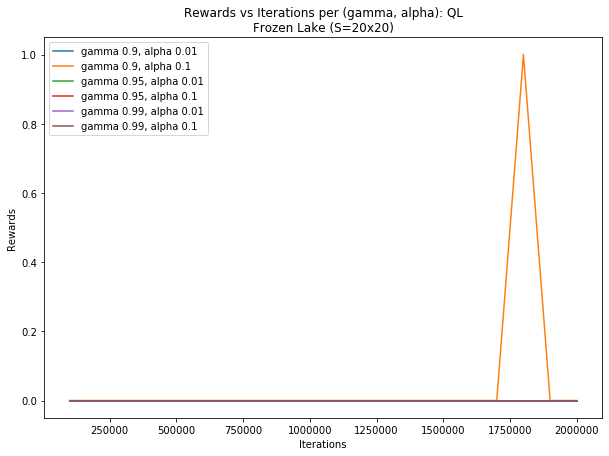

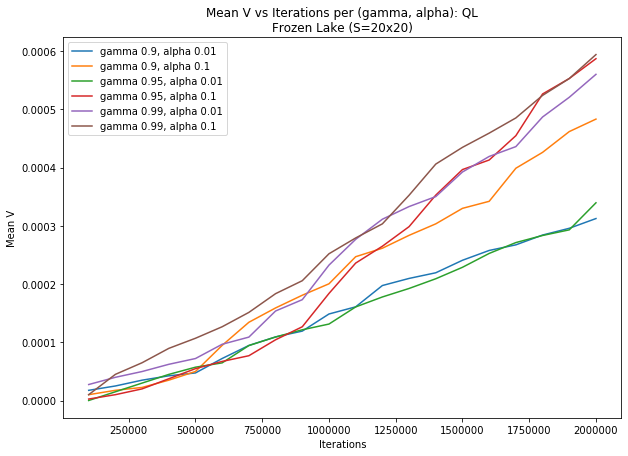

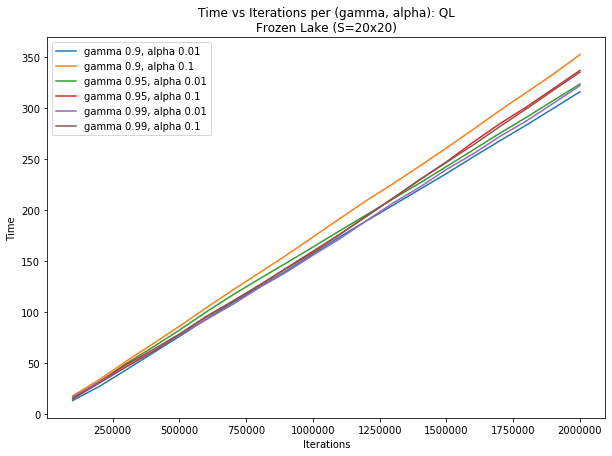

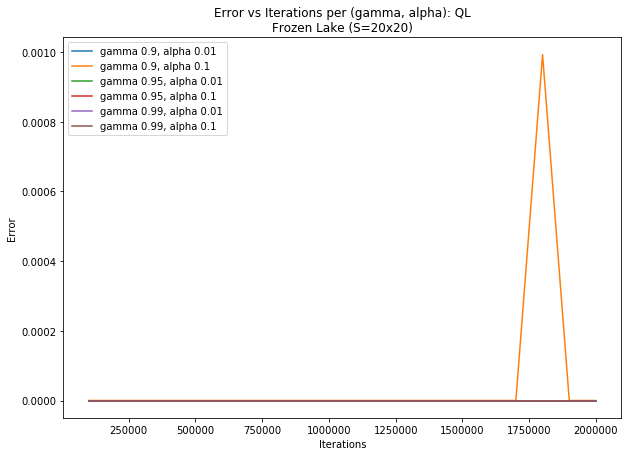

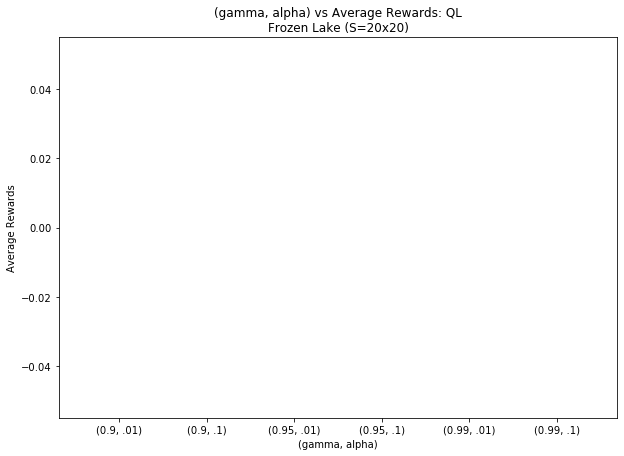

In [12]:
#QL LARGER GRID WORLD
env, trans_m, reward_m, env_state = setup_game('20x20')
# hparams tuning
# gamma and alpha
gamma = [.9, .95, .99]
alpha = [.01, .1]

# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
iters = 2000000

for g in gamma:
    for a in alpha:
        ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=g, alpha=a, n_iter=iters, run_stat_frequency=100000)
        ql.run()
        episode_results = []
        episode_rewards = []
        # play game
        for i_episode in range(N_EPISODES):
            state = env.reset() # reset state to s0.
            moves = 0
            done = False
            total_rewards = 0
            while not done:
                action = ql.policy[state]
                state, reward, done, info = env.step(action)
                moves += 1
                total_rewards += reward      
            env.close()
            episode_rewards.append(total_rewards)
        ave_rewards = sum(episode_rewards) / N_EPISODES
        avg_episode_rewards.append(ave_rewards)
 
        ql_iters = [stat['Iteration'] for stat in ql.run_stats]

        reward_stats = [stat['Reward'] for stat in ql.run_stats]
        plt.figure(1, figsize=[10, 7])
        plt.plot(ql_iters, reward_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Rewards vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=20x20)")
        plt.ylabel("Rewards")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Rewards_vs_Iterations_ql_gamma_larger.png')


        meanv_stats = [stat['Mean V'] for stat in ql.run_stats]
        plt.figure(2, figsize=[10, 7])
        plt.plot(ql_iters, meanv_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Mean V vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=20x20)")
        plt.ylabel("Mean V")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/MeanV_vs_Iterations_ql_gamma_larger.png')

        time_stats = [stat['Time'] for stat in ql.run_stats]
        plt.figure(3, figsize=[10, 7])
        plt.plot(ql_iters, time_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Time vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=20x20)")
        plt.ylabel("Time")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Time_vs_Iterations_ql_gamma_larger.png')

        err_stats = [stat['Error'] for stat in ql.run_stats]
        plt.figure(4, figsize=[10, 7])
        plt.plot(ql_iters, err_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Error vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=20x20)")
        plt.ylabel("Error")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Error_vs_Iterations_ql_gamma_larger.png')

tick_labels = ['(0.9, .01)', '(0.9, .1)', '(0.95, .01)', '(0.95, .1)', '(0.99, .01)', '(0.99, .1)']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5, figsize=[10, 7])
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("(gamma, alpha) vs Average Rewards: QL\nFrozen Lake (S=20x20)")
plt.xlabel("(gamma, alpha)")
plt.ylabel("Average Rewards")
plt.savefig('../images/ql_frozen/Average_Rewards_vs_Gamma_ql_larger.png')


Time: 328.6550118923187
Policy: (0, 0, 3, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 3, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, 1, 1, 0, 1, 1, 0, 0, 2, 3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 2, 1, 0, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 3, 3, 2, 1, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, 2, 0, 3, 3, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 3, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 3, 2, 3, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 3, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 3, 3, 0, 0, 0, 0, 0, 1, 1, 3, 2, 0, 0, 2, 2

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


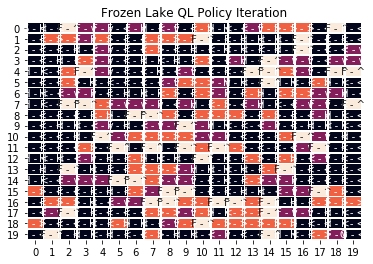

In [13]:
# Show Optimal policy LARGER GRID WORLD
ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=.9, alpha=.1, n_iter=iters, run_stat_frequency=100000)
ql.run()
print('Time: ' + str(ql.time))
print('Policy: ' + str(ql.policy))
print('Value: ' + str(ql.V))
# Did they converge to the same policy?
print(ql.policy == pi_large.policy)
print(ql.policy == vi_large.policy)
visualize_policy(ql.policy, rl_type='QL', env_state=env_state)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4


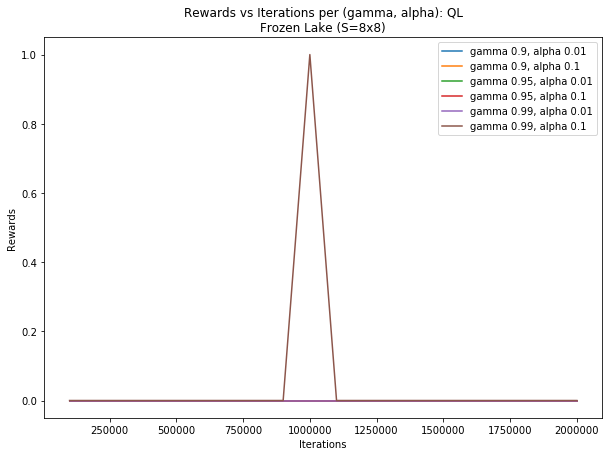

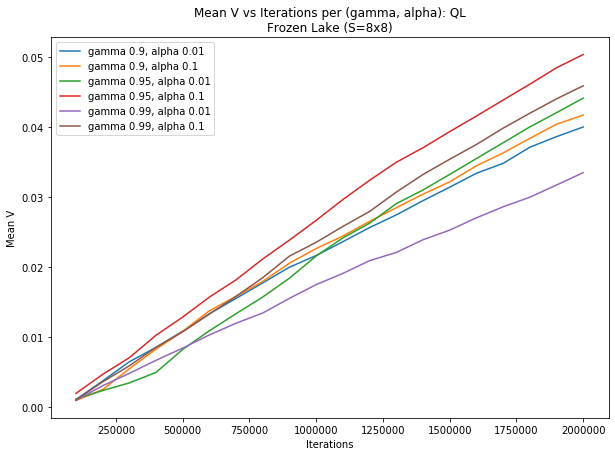

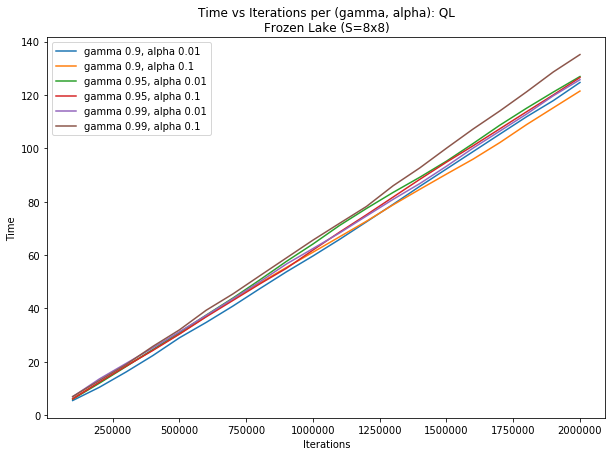

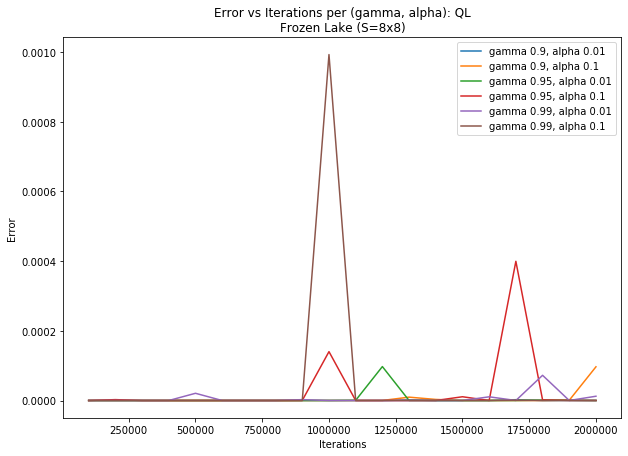

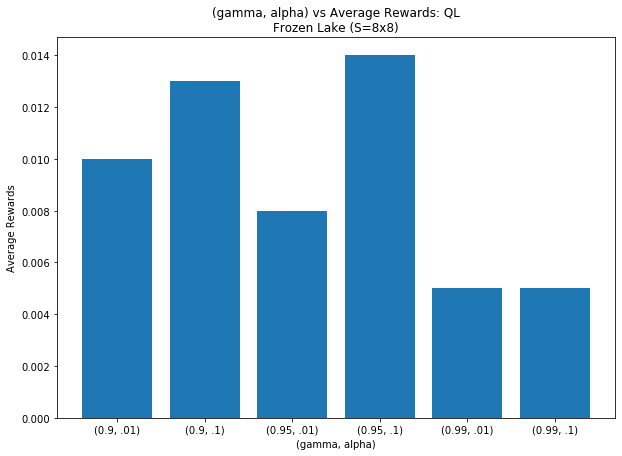

In [14]:
#QL
env, trans_m, reward_m, env_state = setup_game('8x8')
# hparams tuning
# gamma and alpha
gamma = [.9, .95, .99]
alpha = [.01, .1]

# test each policy by playing the game, step x step, taking the optimal action in the policy
avg_episode_rewards = []
iters = 2000000

for g in gamma:
    for a in alpha:
        ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=g, alpha=a, n_iter=iters, run_stat_frequency=100000)
        ql.run()
        episode_results = []
        episode_rewards = []
        # play game
        for i_episode in range(N_EPISODES):
            state = env.reset() # reset state to s0.
            moves = 0
            done = False
            total_rewards = 0
            while not done:
                action = ql.policy[state]
                state, reward, done, info = env.step(action)
                moves += 1
                total_rewards += reward      
            env.close()
            episode_rewards.append(total_rewards)
        ave_rewards = sum(episode_rewards) / N_EPISODES
        avg_episode_rewards.append(ave_rewards)
 
        ql_iters = [stat['Iteration'] for stat in ql.run_stats]

        reward_stats = [stat['Reward'] for stat in ql.run_stats]
        plt.figure(1, figsize=[10, 7])
        plt.plot(ql_iters, reward_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Rewards vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=8x8)")
        plt.ylabel("Rewards")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Rewards_vs_Iterations_ql_gamma.png')


        meanv_stats = [stat['Mean V'] for stat in ql.run_stats]
        plt.figure(2, figsize=[10, 7])
        plt.plot(ql_iters, meanv_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Mean V vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=8x8)")
        plt.ylabel("Mean V")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/MeanV_vs_Iterations_ql_gamma.png')

        time_stats = [stat['Time'] for stat in ql.run_stats]
        plt.figure(3, figsize=[10, 7])
        plt.plot(ql_iters, time_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Time vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=8x8)")
        plt.ylabel("Time")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Time_vs_Iterations_ql_gamma.png')

        err_stats = [stat['Error'] for stat in ql.run_stats]
        plt.figure(4, figsize=[10, 7])
        plt.plot(ql_iters, err_stats, label="gamma " + str(g)  + ", alpha " + str(a))
        plt.legend()
        plt.title("Error vs Iterations per (gamma, alpha): QL\nFrozen Lake (S=8x8)")
        plt.ylabel("Error")
        plt.xlabel("Iterations")
        plt.savefig('../images/ql_frozen/Error_vs_Iterations_ql_gamma.png')

tick_labels = ['(0.9, .01)', '(0.9, .1)', '(0.95, .01)', '(0.95, .1)', '(0.99, .01)', '(0.99, .1)']
x = np.arange(len(tick_labels)) # tick positions
plt.figure(5, figsize=[10, 7])
plt.bar(x, avg_episode_rewards, tick_label=tick_labels)
plt.title("(gamma, alpha) vs Average Rewards: QL\nFrozen Lake (S=8x8)")
plt.xlabel("(gamma, alpha)")
plt.ylabel("Average Rewards")
plt.savefig('../images/ql_frozen/Average_Rewards_vs_Gamma_ql.png')



SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFFF
FFFHFFFG
# States: 64
# Actions: 4
Time: 118.48973321914673
Policy: (3, 1, 3, 2, 2, 1, 2, 2, 1, 2, 1, 3, 2, 3, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 1, 0, 3, 0, 0, 3, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 1, 3, 3, 0, 3, 2, 1, 0)
Value: (5.905641976571186e-10, 5.299564369828623e-09, 4.8827385564411125e-08, 6.011820198847327e-07, 4.7821989373470925e-06, 1.5985759330349968e-05, 6.562190755297845e-05, 0.00026750168239451656, 2.9649420246597897e-10, 9.411849644021207e-09, 7.59495504098295e-08, 6.784580001754338e-07, 6.920302188675755e-06, 2.947012120835573e-05, 0.00012696177173383093, 0.0004593377069578223, 2.4710886001009535e-10, 5.398563679975427e-09, 3.750950447858065e-08, 0.0, 8.798077387454117e-06, 2.6183271188646026e-05, 0.00015939062820215967, 0.001048029826541279, 1.326273770094153e-09, 2.7599138054554704e-08, 3.537529083570165e-07, 3.4223771845680125e-06, 4.5150220590363595e-05, 0.0, 0.0

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


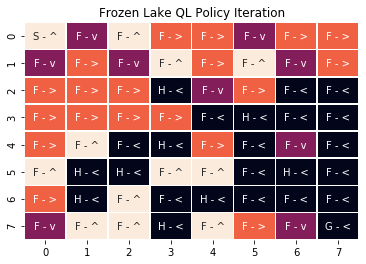

In [16]:
# Show Optimal policy
env, trans_m, reward_m, env_state = setup_game('8x8')
iters = 2000000
ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=.95, alpha=.1, n_iter=iters, run_stat_frequency=100000)
ql.run()
print('Time: ' + str(ql.time))
print('Policy: ' + str(ql.policy))
print('Value: ' + str(ql.V))
# Did they converge to the same policy?
print(ql.policy == pi.policy)
print(ql.policy == vi.policy)
visualize_policy(ql.policy, rl_type='QL', env_state=env_state)

In [3]:
def visualize_policy(policy, rl_type, env_state):    
    action_taken = {0: '<', 1: 'v', 2: '>', 3: '^'}
    
    dim = int(np.sqrt(env.nS))
    state_arr = (dim, dim)
    # reshape tuple as array
    policy_arr = np.reshape(policy, state_arr)
    print(policy_arr)
    policy_labels = np.vectorize(action_taken.get)(policy)
    e_state = [item for sublist in env_state for item in sublist]
    

    for a in policy:
        # add the state labels
        temp = []
        for x, y in np.nditer([policy_labels, e_state]):
            x = ' - '.join([str(y), str(x)])
            temp.append(x)
    policy_labels = np.reshape(temp, state_arr)
    
    plot = sns.heatmap(policy_arr, annot=policy_labels, fmt='', linewidth=.6, cbar=False)
    title = f'Frozen Lake {rl_type} Policy Iteration' 
    plot.title.set_text(title)
    fig = plot.get_figure()
    fig.savefig('../images/' + rl_type.lower() + '_frozen/policy_frozen_' + rl_type + '_' + str(dim) + '_x_' + str(dim) + '_.png')
    fig.show()      

In [ ]:
# Taken as is from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


In [ ]:
# Used to initially generate constant maps 
m = generate_random_map(size=20)
print(m)